## Path sampling

This notebook contains the code for Qijia's path sampling idea.

First, imports:

In [1]:
import jax
import jax.numpy as jnp
from nn import MLP, train
import numpy as np
import matplotlib.pyplot as plt
import optax 
import scipy
import os
from functools import partial
from path_sampling import dfdt, div_f, update, update_non_amortized


`batch_size` is the number of paths (that we use each time we update the drift)

`ndims` is the number of dimensions of the problem. Here we work with a TPS example, of a double well in 2D.

In [2]:
# this allows for parallelization with pmap. Not currently used
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=" + str(200)

# currently we're just doing an SDE on \mathbb{R}
ndims = 1


We now define a function that generates random paths given a drift term `b` and a noise term `W`:

## Example of a path in a double well

Here's an example of sampling a path in a double well potential.

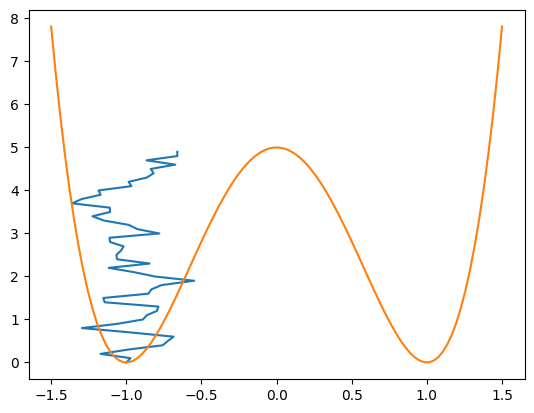

In [3]:
from path_sampling import make_double_well_potential, sample_sde


hyperparams={'dt': 0.01, 'num_steps': 50, 'num_training_steps' : 1000}


potential = make_double_well_potential(v=5.0)

def uref(x, t): 
    # potential = lambda x: jnp.sum(x**4 - 8 * x**2,axis=-1)
    return -jax.grad(potential)(x)

path, time = sample_sde(
    b=uref, 
    W = lambda _, key: jnp.sqrt(2)*jax.random.normal(key, shape=(ndims,)),
    rho = lambda key: jnp.zeros((ndims,))-1.,
    key=jax.random.key(0), 
    dt=hyperparams['dt'], 
    num_steps=hyperparams['num_steps'])

# visualize path
plt.plot(path,time*10)
# plot potential
x = np.linspace(-1.5, 1.5, 100)

plt.plot(x, potential(x[:, None]))

## Brownian motion prior, brownian bridge posterior

sorry about the background double well - just there by default - there's no double well potential in this example!

Schedule: [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 1.0]
old s 0.0
Train loss: 2327660.75
Test loss is 1791503.5
old s 0.1
Train loss: 1858414.0
Test loss is 1857928.375
old s 0.2
Train loss: 62525.41015625
Test loss is 63622.46875
old s 0.3
Train loss: 46872.0234375
Test loss is 44849.84375
old s 0.4
Train loss: 36565.9453125
Test loss is 40841.02734375
old s 0.5
Train loss: 34155.5703125
Test loss is 34557.046875
old s 0.6
Train loss: 26028.69921875
Test loss is 33155.30078125
old s 0.7
Train loss: 29526.115234375
Test loss is 30860.81640625
old s 0.8
Train loss: 24465.38671875
Test loss is 24182.876953125
old s 0.85
Train loss: 18355.13671875
Test loss is 19352.611328125
old s 0.9
Train loss: 17287.05859375
Test loss is 19872.380859375
old s 0.95
Train loss: 16610.71875
Test loss is 17756.908203125


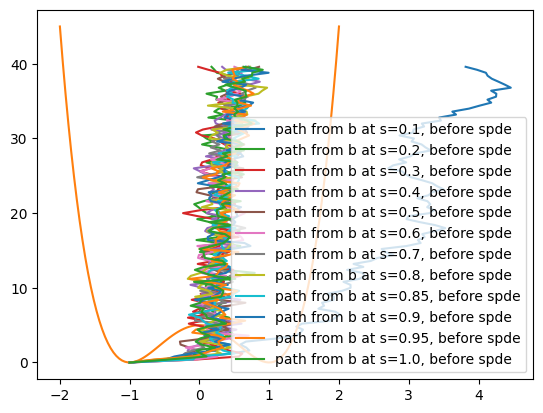

In [10]:
key = jax.random.key(0)
# schedule = np.linspace(0,1, 5)
schedule = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 1.0] # obviously should be extended to 1, but just to see early steps...
print("Schedule:", schedule)

hyperparams={'dt': 0.01, 'num_steps': 100, 'num_training_steps' : 1000, 'batch_size' : 200}

b = lambda x, t: 0.0
A = 0
dbds = MLP([3,20,20,1], key=jax.random.key(1))
for i, s in enumerate(schedule):



    key = jax.random.fold_in(key, i)

    # for simplicity, I consider the version where a new NN is learned at each s. The alternative version is commented out below
    b, A = update_non_amortized(
        V=lambda x: 0.0,
        b=b,
        J=lambda x,y: (1/0.1**2)*(x[-1,0]- 1)**2,
        dbds=dbds,
        hyperparams=hyperparams,
        key=key,
        schedule=schedule,
        i=i,
        prior='sde_prior',
        A=A,
        refine=False
    )
    
    # dbds, A = update(
    #     V=lambda x: 0.0,
    #     uref=b,
    #     J=lambda x,y: (1/0.1**2)*(x[-1,0]- 1)**2,
    #     dbds=dbds,
    #     hyperparams=hyperparams,
    #     key=key,
    #     schedule=schedule,
    #     i=i,
    #     prior='sde_prior',
    #     A=A,
    #     refine=True
    # )


## Now use the learned b to generate new paths

In [11]:
from path_sampling import make_b

# if using the version with a single NN (commented out above)
# b = make_b(schedule, uref, dbds)

path_key, model_key, refine_key = jax.random.split(key, 3)

W = lambda _, key: jnp.sqrt(2)*jax.random.normal(key, shape=(ndims,))
xs, times = jax.pmap(lambda key:sample_sde(
b=b, 
W = W,
rho =  lambda key: jnp.zeros((ndims,))-1,
key=key, 
dt=hyperparams['dt'], 
num_steps=hyperparams['num_steps']))(jax.random.split(path_key, 10))

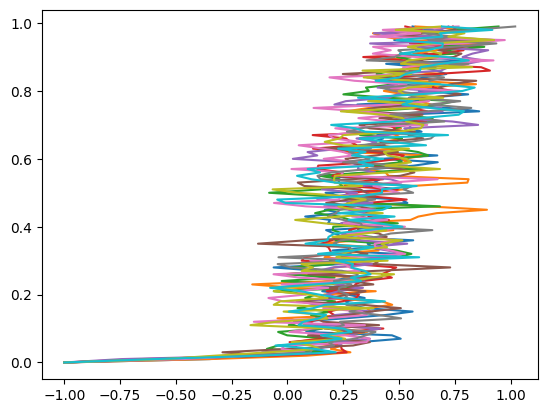

In [12]:
for path in xs:
    plt.plot(path, times[0])

# and compare to exact brownian bridge

(ignore the double well in the background - just a plotting artifact)

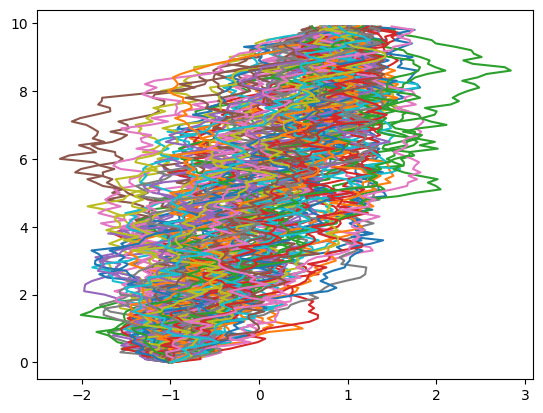

In [10]:
# estimate marginals
from path_sampling import make_double_well_potential, sample_sde


hyperparams={'dt': 0.01, 'num_steps': 100, 'num_training_steps' : 1000}


paths, times = jax.pmap(lambda k: sample_sde(
    b= lambda x,t: (1 - x)/(1-t), 
    W = lambda _, key: jnp.sqrt(2)*jax.random.normal(key, shape=(ndims,)),
    rho = lambda key: jnp.zeros((ndims,))-1.,
    key=k, 
    dt=hyperparams['dt'], 
    num_steps=hyperparams['num_steps']))(jax.random.split(key, 100))

# visualize path
for path, time in zip(paths, times):
    plt.plot(path,time*10)
# plot potential
x = np.linspace(-1.5, 1.5, 100)
